In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cv2
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from sklearn.svm import SVC 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

2023-08-08 14:54:31.577101: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 14:54:31.611832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 14:54:31.612440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 14:54:32.249889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
print("shape of training data (X)" ,X_train.shape)
print("shape of training data(y)" ,y_train.shape)
print("shape of testing data(X)" ,X_test.shape)
print("shape of testing data(y)" ,y_test.shape)

shape of training data (X) (50000, 32, 32, 3)
shape of training data(y) (50000, 1)
shape of testing data(X) (10000, 32, 32, 3)
shape of testing data(y) (10000, 1)


In [4]:
X_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_train])
X_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_test])

In [5]:
print("shape of training data (X)" ,X_train.shape)
print("shape of testing data(X)" ,X_test.shape)

shape of training data (X) (50000, 32, 32)
shape of testing data(X) (10000, 32, 32)


In [6]:
X_train  = X_train/255
X_test  = X_test/255

In [7]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

ohe = OneHotEncoder(sparse=False)
ohe.fit(y_train)

y_train = ohe.transform(y_train)
y_test = ohe.transform(y_test)

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [9]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=(32,32,1)))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(245, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [10]:
history = model.fit(X_train.reshape(50000, 32, 32,1), y_train, epochs=5, 
                    batch_size=32, validation_data=(X_test.reshape(10000, 32, 32,1), y_test), callbacks=[stop])

Epoch 1/5
1563/1563 [==============================] - 104s 66ms/step - loss: 1.7618 - acc: 0.3443 - val_loss: 1.4476 - val_acc: 0.4729
Epoch 2/5
1563/1563 [==============================] - 105s 67ms/step - loss: 1.3542 - acc: 0.5150 - val_loss: 1.1902 - val_acc: 0.5747
Epoch 3/5
1563/1563 [==============================] - 106s 68ms/step - loss: 1.1394 - acc: 0.5984 - val_loss: 1.0090 - val_acc: 0.6531
Epoch 4/5
1563/1563 [==============================] - 106s 68ms/step - loss: 1.0176 - acc: 0.6456 - val_loss: 0.9656 - val_acc: 0.6657
Epoch 5/5
1563/1563 [==============================] - 107s 68ms/step - loss: 0.9294 - acc: 0.6785 - val_loss: 0.9297 - val_acc: 0.6793


In [11]:
cnn_pred = model.predict(X_test.reshape(10000,32,32,1))
cnn_pred = ohe.inverse_transform(cnn_pred)

313/313 [==============================] - 3s 9ms/step


In [12]:
y_test = ohe.inverse_transform(y_test)

In [13]:
ac=accuracy_score(y_test , cnn_pred)
print("Accuracy using CNN: ",ac*100)

Accuracy using CNN:  67.93


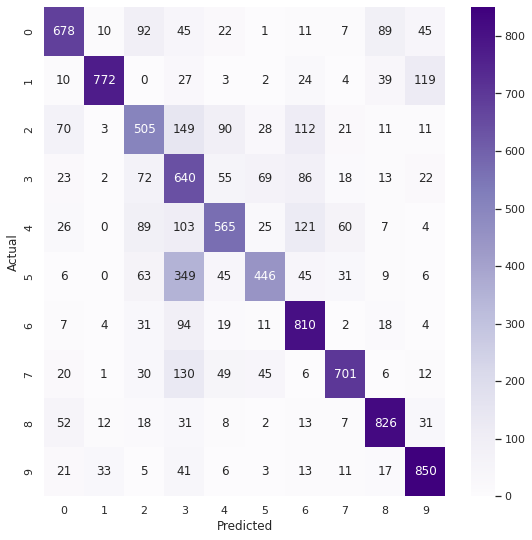

In [14]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, cnn_pred), fmt='d', annot=True, cmap=plt.cm.Purples)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

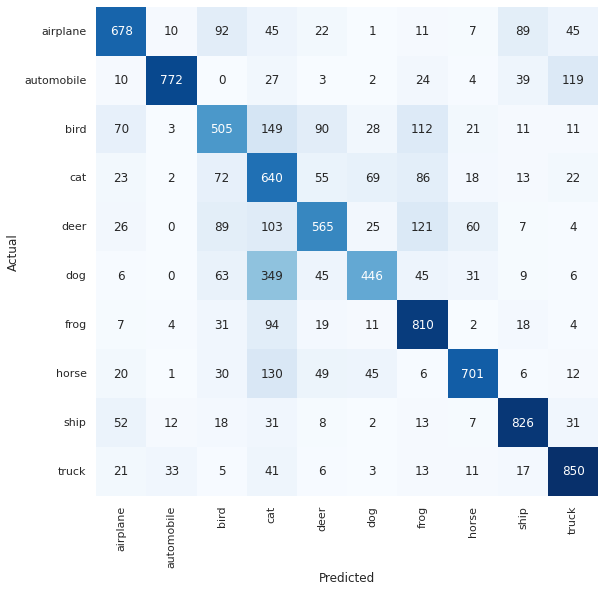

In [15]:
cm = confusion_matrix(y_test, cnn_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
arr=[]
for i in X_train:
  i=i.ravel()
  arr.append(i)
arr2=[]
for i in X_test:
  i=i.ravel()
  arr2.append(i)

In [17]:
df_test=pd.DataFrame(arr2)
df_test.shape

(10000, 1024)

In [18]:
df=pd.DataFrame(arr)

In [19]:
df.shape

(50000, 1024)

In [20]:
data=pd.concat([df , df_test],axis=0)

In [21]:
data.shape

(60000, 1024)

In [22]:
y_train=ohe.inverse_transform(y_train)

In [ ]:
svm=SVC(C=1.0, kernel='linear', gamma='scale', 
                cache_size=200, class_weight=None, verbose=True, max_iter=- 1,random_state=42)

In [ ]:
svm_pred=svm.predict(df_test)

In [ ]:
print("Accuracy using SVM classifier: ",accuracy_score(y_test , svm_pred)*100)

In [ ]:
lda=LinearDiscriminantAnalysis()
lda.fit(df, y_train.ravel())

In [ ]:
lda_pred=lda.predict(df_test)

In [ ]:
print("Accuracy using LDA: ",accuracy_score(y_test , lda_pred)*100)

In [ ]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(df, y_train.ravel())

xg_pred = xgb_model.predict(df_test)

In [ ]:
print("Accuracy using XGBoost: ", accuracy_score(y_test , xg_pred)*100)

In [ ]:
rfc = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 42)
rfc.fit(df, y_train.ravel())

In [ ]:
rfc_pred=rfc.predict(df_test)

In [ ]:
print("Accuracy using RF Classifier: ", accuracy_score(y_test , rfc_pred)*100)

In [ ]:
gnb = GaussianNB().fit(df, y_train.ravel())
gnb_pred = gnb.predict(df_test)

In [ ]:
acc = gnb.score(y_test, gnb_pred)

In [ ]:
print("Accuracy using Gaussian NB: ", acc*100)